## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The goal of this project is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision by performing A/B test.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` a. Now, read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
len(df['user_id'].unique())

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
new_control_df = df[(df['landing_page'] == 'new_page') & (df['group'] == 'control')]
old_treatment_df = df[(df['landing_page'] == 'old_page') & (df['group'] == 'treatment')]

len(new_control_df) + len(old_treatment_df)

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  We need to remove these rows. 

In [8]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` a. How many unique **user_id**s are in **df2**?

In [10]:
len(df2['user_id'].unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**.

In [13]:
print('before:', df2.shape[0], 'rows')

df2 = df2.drop_duplicates(['user_id'])

print('after:', df2.shape[0], 'rows')

before: 290585 rows
after: 290584 rows


`4.` 
a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

As we can see above, the probability of conversion of an individual in control group is around 12,03% and the same probability in treatment group is 11,88%, which means that for now we do not have enough evidence to conclude that the new treatment page leads to more conversions. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is should we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, let's consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  

- **Null hypothesis**: the old page is better or the same as the new one

$H_{0}$: **$p_{new}$** - **$p_{old}$** ≤ 0

- **Alternative hypothesis**: the new page is better that the old one

$H_{1}$: **$p_{new}$** - **$p_{old}$** > 0

`2.` Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

That means that conversion rate for 𝑝𝑛𝑒𝑤 under the null is the same as the conversion rate for the entire dataset:

a.  **Conversion rate** for $p_{new}$ under the null

In [18]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. **Conversion rate** for $p_{old}$ under the null 

In [19]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0,1], n_new, [(1-p_new) ,p_new])
new_page_converted

array([1, 1, 1, ..., 0, 0, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0,1], n_old, [(1-p_old) ,p_old])
old_page_converted

array([0, 1, 1, ..., 0, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
(new_page_converted).mean() - (old_page_converted).mean()

0.000584995523877252

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
new_convert = np.random.binomial(n_new,p_new,10000)/n_new
old_convert = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs = new_convert - old_convert

i. Plot a histogram of the **p_diffs**. 

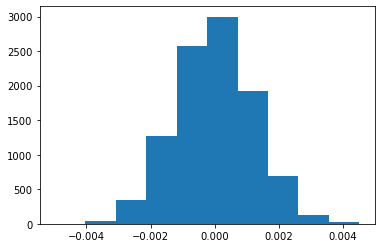

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

(p_diffs > obs_diff).mean()

0.9034

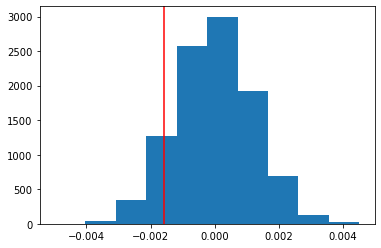

In [28]:
plt.hist(p_diffs);
plt.axvline(obs_diff, c='red');

In the part **j** I computed p-value. Value of 0.9 is much greater than type I error rate of 0.05, which means that based on the data we failed to reject the null hypothesis and we should stay with it.

l. We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Calculate the number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = sum((df2['group'] == 'control') & (df2['converted'] == 1))
convert_new = sum((df2['group'] == 'treatment') & (df2['converted'] == 1))
n_old = sum(df2['group'] == 'control')
n_new = sum(df2['group'] == 'treatment')

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value. 

In [30]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

In the last cell, we saw that the z-score is -1.31 and p-value is 0.905. P-value is very close to the one computed in **j** part, and it is still greater than type I error rate of 0.05, so our conclusion does not change. 

And z-score below 1.5 means that the convertion rate for the new page is less than he 95% of the old page, so we failed to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1`. In this final part, we will compare the results we achieved in the A/B test in Part II above to the results achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, we should perform logistic regression. Besides, we will use dummy variables to transform a categorical column into a quantative one.

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. However, first we will need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. **ab_page** column has 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
import statsmodels.api as sm 
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

In [32]:
# import, inistatiate and fit the regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [33]:
#provide summary
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-09-11 17:21 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

Our hypothesis in Part 3:
- $H_{0}$: **$p_{new}$** - **$p_{old}$** = 0
- $H_{1}$: **$p_{new}$** - **$p_{old}$** ≠ 0

P-value associated with **ab-page** is almost 0.190, which is greater than 0.05, and we again failed to reject the null hypothesis.

`2`. It is useful to consider other things and add other factors to the model in order to find the variables that might impact whether or not an individual converts. However, we should be careful. As a disadvantage of adding additional variables, the model might give unpredictable results, if our dataset is too small or we add too many variables.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together datasets on the appropriate rows. 

In [34]:
countries_df = pd.read_csv('countries.csv')
df3 = pd.merge(df2, countries_df, on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [35]:
df3['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [36]:
#creating dummy variables for countries
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [37]:
log_mod = sm.Logit(df3['converted'],df3[['intercept','UK','US']])
log_mod.fit().summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2020-09-11 17:21 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

All of the p-values are above 0.05, so none is significantly meaningful and we fail to reject the null.

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Let's create the necessary additional columns, and fit the new model. 

In [38]:
df3['UK_ab_page'] = df3['UK']*df3['ab_page']
df3['CA_ab_page'] = df3['CA']*df3['ab_page']
logit3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])

results = logit3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-09-11 17:21 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

In the logistic regression model for interactions of page and countries, p-values are again too high and we can affirm that the values do not show any substantial difference in the conversion rates for control group and treatment group.

## Conclusions

We got similar results from bootstrapping and regression models, none of the p-values were smaller than 0.05 and every time we failed to reject the Null Hypothesis. Therefore, we should accept it and the e-commerce company has no reason to change the page, at least for this one. Although, they might try to improve the page even more to get different results.